## Polars

Polars is a lightning fast DataFrame library. The [key features](https://docs.pola.rs/) of polars are:

**Fast and Accessible**: Written from scratch in Rust, designed close to the machine and without external dependencies. It also has python and R bindings!

**I/O**: First class support for all common data storage layers: local, cloud storage & databases.

**Handle Datasets** larger than RAM

**Intuitive API**: Write your queries the way they were intended. Polars, internally, will determine the most efficient way to execute using its query optimizer.
Out of Core: The streaming API allows you to process your results without requiring all your data to be in memory at the same time

**Parallel**: Utilises the power of your machine by dividing the workload among the available CPU cores without any additional configuration.


The philosophy of Polars is to provide a dataframe library that utilises available cores, has an intuitive api and is performant - hence adheres to a strict schema (data-types should be known before running the query).

![polars](../fig/polars.png)

### Polars concepts

Data Frames and Series are the primary data structures supported by polars. Polars describes common operations available as [Contexts](https://docs.pola.rs/user-guide/concepts/contexts/) and [Expressions](https://docs.pola.rs/user-guide/concepts/expressions/). 

Expressions are essentially data transformations. Polars automatically makes each expression parallel - a main reason why polars is so quick. Within an expression there may be multiple expressions and parallelization going on. Polars performs query optimisations on every expression.

Contexts refers to the context in which an expression needs to be evaluated. Specifically: 
  

- **select** : selecting columns

- **filter** : filtering rows

- **with_columns** : create / do something with columns

- **group_by** : group by a factor and follow with

- **agg** : aggregation
    

In [18]:
# fetching some data ----------------------------------------------------------------
import polars as pl
from datetime import datetime
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo # fetch iris dataset
import pandas as pd

iris = fetch_ucirepo(id=53) 
X = iris.data.features 
y = iris.data.targets 
iris_df = pd.concat([X, y], axis=1)
iris_df.rename(columns={'class': 'species'}, inplace=True)
iris_df.to_csv("iris_data.csv", index=False)

# load a pandas.DataFrame into a polars.DataFrame
df = pl.DataFrame(
    {
        "integer": [1, 2, 3,4],
        "date": [
            datetime(2025, 1, 1),
            datetime(2025, 1, 2),
            datetime(2025, 1, 3),
            datetime(2025, 1, 3),
        ],
        "float": [4.0, 5.0, 6.0,12],
        "string": ["a", "b", "c","b"],
    }
)
# Series types need to be the same
sr = pl.Series([1,2,3,4,500])
# can specify the data types for better performance
sr = pl.Series([1,2,3,4,500],dtype=pl.Int64)

In [6]:
# To inspect the data
df.describe() #sumamry statistics
df.schema #column names and types
df.sample(n=2) # random sample of n rows
df.head(3)

integer,date,float,string
i64,datetime[μs],f64,str
1,2025-01-01 00:00:00,4.0,"""a"""
2,2025-01-02 00:00:00,5.0,"""b"""
3,2025-01-03 00:00:00,6.0,"""c"""


## Getting to know the syntax

We will cover some basic syntax. Check out the [API documentation](https://docs.pola.rs/api/python/stable/reference/index.html) for more information.

### Reading and Writing Data

Polars support reading and writing data many types of files. It also supporting reading from a database, or cloud storage. See the [IO Documentation](https://docs.pola.rs/user-guide/io/) for more information. 

In [7]:
# writing data to disk
df.write_csv("output.csv")
df.write_parquet("output.parquet")
# reading back into a polars dataframe
new_df = pl.read_csv("output.csv")
new_df = pl.read_parquet("output.parquet")

# can convert back to pandas dataframe (or other types)
df.to_pandas() 

,integer,date,float,string
0,1,2025-01-01,4.0,a
1,2,2025-01-02,5.0,b
2,3,2025-01-03,6.0,c
3,4,2025-01-03,12.0,b


In [8]:
# selecting columns ----------------------------------------------------------------

df.select(pl.col("float")) # selecting a column

df.select(pl.col("date","string")) # selecting multiple columns 

df.select(pl.col("*").exclude("string")) # select all columns then exclude

df.select(pl.col("^(da|fl).*$")) # supports regular expressions

# selectors are intuitive helper funtions for selecting columns by name or type
import polars.selectors as cs   

df.select(cs.integer() | cs.contains("ate")) # select all columns that are integers or contains ate

# filtering rows ---------------------------------------------------------------------

df.filter(pl.col("integer") >= 2)  #filtering rows

df.filter((pl.col("integer") >=2) & 
          (pl.col("float") == 5.0)) #filtering rows with multiple conditions (| = or & = and)

#creating / manipulating columns -----------------------------------------------------

df.with_columns((pl.col("integer") + 3).alias("new_column")) # creating column and naming it

#group by aggregations ----------------------------------------------------------------

df.group_by("string").agg(pl.col("integer").sum().alias("sum"),
                          pl.col("date").sort().first().alias("earliest"), 
                          pl.col("float") / pl.col("integer")) 
                                

string,sum,earliest,float
str,i64,datetime[μs],list[f64]
"""b""",6,2025-01-02 00:00:00,"[2.5, 3.0]"
"""a""",1,2025-01-01 00:00:00,[4.0]
"""c""",3,2025-01-03 00:00:00,[2.0]


In [9]:
# Can combine expressions for compactness

df3 = df.with_columns((pl.col("float") * pl.col("integer"))
                .alias("product")).select(pl.all().exclude("integer"))

### Links to documentation:


[Selecting columns](https://docs.pola.rs/user-guide/expressions/column-selections/)

[Aggregation](https://docs.pola.rs/user-guide/expressions/aggregation/)

[Data Transformation](https://docs.pola.rs/user-guide/transformations/) such as join, Concatenation, pivot and unpivot. 

[Functions for expressions](https://docs.pola.rs/api/python/stable/reference/expressions/functions.html/). 



### Data types and casting

Most [data types](https://docs.pola.rs/user-guide/concepts/data-types/overview/) are specified by the arrow syntax with the exception of String, Categorical and Object types.

**Categorical** data represents string data where the values in the column have a finite set of values (yet for performance implementation different to strings). Polars supports both **Enum** data type, where categories are known up front, and the more flexible Categorical data type where values are not known beforehand. Conversion between them is trivial. Relying on polars inferring the categories with Categorical types comes at a performance cost. See [Categorical](https://docs.pola.rs/user-guide/concepts/data-types/categoricals/#categorical-data-type) page for more information.

Casting (changing the datatypes) is enabled by either specifying the dtype argument or applying the cast() function.

In [10]:
# Use Enum where categories are known
cat_types = pl.Enum(["polar","panda","teddy"])
animals = pl.Series(["polar","polar","teddy","panda"],dtype= cat_types)
# Use Categprical otherwise
fictional_animals = pl.Series(["poobear","minimouse","teddy","poobear"],dtype= pl.Categorical)

# casting columns to other data types with cast
df.cast({"integer": pl.Float32, "float": pl.UInt8})


integer,date,float,string
f32,datetime[μs],u8,str
1.0,2025-01-01 00:00:00,4,"""a"""
2.0,2025-01-02 00:00:00,5,"""b"""
3.0,2025-01-03 00:00:00,6,"""c"""
4.0,2025-01-03 00:00:00,12,"""b"""


## Lazy / Eager and Streaming

Polars supports two modes of operation: lazy and eager. In the eager API the query is executed immediately while in the lazy API the query is only evaluated once it is 'needed'. Deferring the execution to the last minute can have significant performance advantages.


An example of using the eager API is below. Every step is executed immediately returning the intermediate results. This can be very wasteful as we might do work or load extra data that is not being used.


In [11]:
df = pl.read_csv("iris_data.csv") #read the iris dataset
df_small = df.filter(pl.col("sepal length") > 5) #filter
df_agg = df_small.group_by("species").agg(pl.col("sepal width").mean()) #mean of the sepal width per species

If we instead used the lazy API and waited on execution until all the steps are defined then the query planner could perform various optimizations. 

In [12]:
q = (
    pl.scan_csv("iris_data.csv") #doesnt read it all before other operation is performed
        .filter(pl.col("sepal length") > 5)
        .group_by("species").agg(pl.col("sepal width").mean())
)

q # a lazyframe

df_agg = q.collect() # inform polars that you want to execute the query
df_agg = q.collect(streaming=True) # with streaming mode to process in batches

**Streaming** 

One additional benefit of the lazy API is that it allows queries to be executed in a streaming manner. Instead of processing the data all-at-once Polars can execute the query in batches allowing you to process datasets that are larger-than-memory. See [here](https://docs.pola.rs/user-guide/concepts/streaming/#when-is-streaming-available) for more info on streaming.

**When to use Lazy versus Eager**:

In general the lazy API should be preferred unless you are either interested in the intermediate results or are doing exploratory work and don't know yet what your query is going to look like

When using Lazy mode, apply filteres as early as possible before reading the data. Only select column you need.

### Common Machine Learning Workflow

Given your new knowledge of polars, here is an example on how to integrate into the usual pipeline consisting of data ingestion and manipulation, model preperation and prediction.

In [15]:
# loading libraries
!pip install ucimlrepo
!pip install scikit-learn==1.4
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from matplotlib import pylab as plt

In [14]:
# Fit a descision tree from polars dataframe object
df = pl.read_csv("iris_data.csv")
data = df.select(['sepal length', 'sepal width', 'petal length', 'petal width'])
target = df.select(['species']).to_series()
clf = DecisionTreeClassifier()
model = clf.fit(data, target)

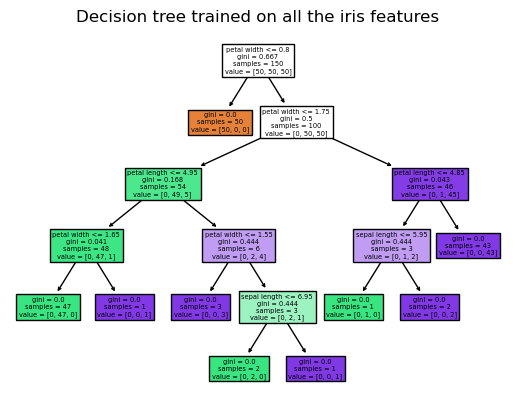

In [16]:
# Plot the decision tree
plot_tree(clf, filled=True, feature_names=data.columns)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [17]:
# Add predicitions to the polars dataframe
predict_df = pl.concat([df,
                        pl.DataFrame(model.predict(data), schema=["predict"])],
                       how="horizontal")
print(predict_df.sample(8))

shape: (8, 6)
┌──────────────┬─────────────┬──────────────┬─────────────┬─────────────────┬─────────────────┐
│ sepal length ┆ sepal width ┆ petal length ┆ petal width ┆ species         ┆ predict         │
│ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---             ┆ ---             │
│ f64          ┆ f64         ┆ f64          ┆ f64         ┆ str             ┆ str             │
╞══════════════╪═════════════╪══════════════╪═════════════╪═════════════════╪═════════════════╡
│ 6.0          ┆ 3.4         ┆ 4.5          ┆ 1.6         ┆ Iris-versicolor ┆ Iris-versicolor │
│ 6.3          ┆ 2.8         ┆ 5.1          ┆ 1.5         ┆ Iris-virginica  ┆ Iris-virginica  │
│ 5.7          ┆ 4.4         ┆ 1.5          ┆ 0.4         ┆ Iris-setosa     ┆ Iris-setosa     │
│ 5.8          ┆ 2.7         ┆ 5.1          ┆ 1.9         ┆ Iris-virginica  ┆ Iris-virginica  │
│ 6.6          ┆ 3.0         ┆ 4.4          ┆ 1.4         ┆ Iris-versicolor ┆ Iris-versicolor │
│ 6.9          ┆ 3.1      

## Ecosystem

On the [Supported Polars Ecosystem](https://docs.pola.rs/user-guide/ecosystem/#key-features) page you can find a non-exhaustive list of libraries and tools that support Polars. 

As the data ecosystem is evolving fast, more libraries will likely support Polars in the future.



